In [1]:
from save_activations import load_activation_probing_dataset, load_activation_probing_dataset_args
from feature_datasets import common
from probes.evaluation import *

/home/nick/desk/ustyuzhanin/llm/world-models/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def get_target_values(entity_df, feature_name):
    if feature_name == 'coords':
        target = entity_df[['longitude', 'latitude']].values

    elif feature_name.endswith('date') or feature_name.endswith('year'):
        if feature_name == 'death_year':
            target = entity_df[feature_name].values
        else:
            NS_PER_YEAR = 1e9 * 60 * 60 * 24 * 365.25
            target = pd.to_datetime(entity_df[feature_name]).values
            target = target.astype(np.int64) / NS_PER_YEAR
    else:
        raise ValueError(f'Unrecognized feature name: {feature_name}')
    return target

In [3]:
import torch
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt
import tqdm

In [23]:
model = "Llama-2-13b-hf"
feature_name = "release_date"
entity_type = "art"
prompt_name = "empty"
#NUM_LAYERS = 1 # 40

In [24]:
# def run_probe(layer_ix: int, model: str = "Llama-2-13b-hf", entity_type: str = "art", prompt_name: str = "empty"):
activations = load_activation_probing_dataset(model=model, entity_type=entity_type, prompt_name=prompt_name, layer_ix=39)
activations = activations.dequantize()

entity_df = common.load_entity_data(entity_type)
is_test = entity_df.is_test

target = get_target_values(entity_df, feature_name)

train_activations = activations[~is_test]
train_target = target[~is_test]

test_activations = activations[is_test]
test_target = target[is_test]

In [25]:
print(f"activations.shape={activations.shape}")
print(f"target.shape={target.shape}")
print(f"is_test.shape={is_test.shape}")
print(f"is_test.sum()={is_test.sum()}")
7507 / 37539  # So, 1 to 4 test/train size ratio, test size is 20%.

activations.shape=torch.Size([31321, 5120])
target.shape=(31321,)
is_test.shape=(31321,)
is_test.sum()=6437


0.19997868883028316

In [26]:
probe = Ridge(alpha=activations.shape[1])

norm_train_target = (train_target - train_target.mean()
                     ) / train_target.std()

probe.fit(train_activations, norm_train_target)

train_pred = probe.predict(train_activations)
test_pred = probe.predict(test_activations)

train_pred_unnorm = train_pred * train_target.std() + train_target.mean()
test_pred_unnorm = test_pred * train_target.std() + train_target.mean()

train_scores = score_time_probe(train_target, train_pred_unnorm)
test_scores = score_time_probe(test_target, test_pred_unnorm)

scores = {
    **{('train', k): v for k, v in train_scores.items()},
    **{('test', k): v for k, v in test_scores.items()},
}
# return scores

In [27]:
scores

{('train', 'mae'): 5.184383928553714,
 ('train', 'mse'): 51.85337497570832,
 ('train', 'rmse'): 7.200928757855359,
 ('train', 'r2'): 0.8217659551871399,
 ('train', 'pearson'): 0.9070446659616226,
 ('train', 'pearson_p'): 0.0,
 ('train', 'spearman'): 0.8829491602454167,
 ('train', 'spearman_p'): 0.0,
 ('train', 'kendall'): 0.7096994067140758,
 ('train', 'kendall_p'): 0.0,
 ('test', 'mae'): 5.784401241384082,
 ('test', 'mse'): 65.47757599937289,
 ('test', 'rmse'): 8.091821550143878,
 ('test', 'r2'): 0.7695673688115823,
 ('test', 'pearson'): 0.8773096401447807,
 ('test', 'pearson_p'): 0.0,
 ('test', 'spearman'): 0.8470667349146598,
 ('test', 'spearman_p'): 0.0,
 ('test', 'kendall'): 0.6682738474436448,
 ('test', 'kendall_p'): 0.0}

In [15]:
all_scores = []
for layer_ix in tqdm.trange(NUM_LAYERS):
    scores = run_probe(layer_ix)
    all_scores.append(scores)

100%|██████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


In [16]:
test_r2 = [s["test", "r2"] for s in all_scores]
layers = list(range(NUM_LAYERS))

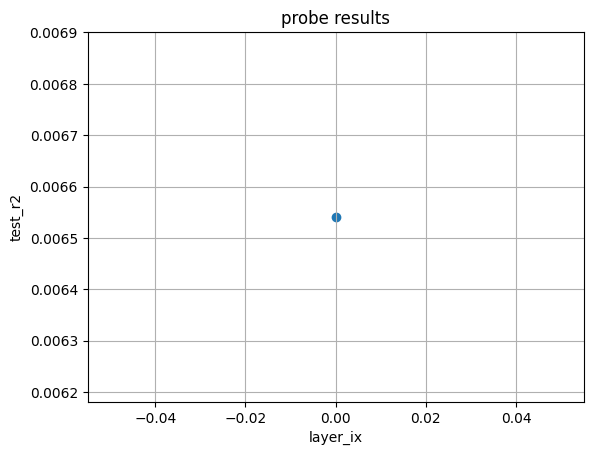

In [22]:
plt.scatter(layers, test_r2)
plt.xlabel("layer_ix")
plt.ylabel("test_r2")
plt.title("probe results")
plt.grid()